In [301]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [302]:
import numpy as np
import matplotlib.pyplot as plt

from neuron_population import NeuronPopulation
from connectome import Connectome
from overhead import Simulation
import networkx as nx
from networkx.algorithms import smallworld
import random
from collections import Counter
from scipy.spatial import cKDTree
from neuron_templates import neuron_type_IZ

In [303]:
dt = 0.1

# Phase I

In [304]:
def phase1_spatial_growth(N, layer_bounds, layer_densities, local_conn_per_node, alpha_init):
    """
    Phase 1: create a purely local spatial network with high clustering.

    N: total number of neurons
    layer_bounds: list of region boundaries or cluster definitions (n_layers, 3, 2)
    layer_densities: relative densities of neurons in each layer (n_layers,)
    local_conn_per_node: max local out-degree per neuron
    alpha_init: initial distance scale parameter
    """

    # Normalized densities
    layer_densities = np.array(layer_densities)
    layer_densities /= np.sum(layer_densities)

    # Neurons per layer
    neurons_per_layer = (layer_densities * N).astype(int)

    coords_layers = []

    for i, (layer_bound, density) in enumerate(zip(layer_bounds, neurons_per_layer)):
        # 1.1. Sample 3D coordinates uniformly within the layer's bounds
        coords = np.random.uniform(layer_bound[:, 0], layer_bound[:, 1], size=(density, 3))
        coords_layers.append(coords)

    # Concatenate all coordinates
    coords = np.concatenate(coords_layers, axis=0)

    # Build KDTree for fast neighbor queries
    tree = cKDTree(coords)

    # Initialize an empty directed graph
    G = nx.DiGraph()
    G.add_nodes_from(range(N))

    # For each neuron, select its local_conn_per_node nearest neighbors
    #      and create edges if distance‐penalized random check passes
    # (We use a high alpha_init so only very short connections form)
    for i in range(N):
        # Find, e.g., 2×local_conn nearest neighbors (so we have a buffer for rejection)
        dists, neighs = tree.query(coords[i], k=2*local_conn_per_node + 1)
        # Skip the first neighbor (itself, dists[0]==0)
        candidates = list(zip(neighs[1:], dists[1:]))
        np.random.shuffle(candidates)
        num_added = 0
        for j, dist_ij in candidates:
            if num_added >= local_conn_per_node: 
                break
            # Connection probability ∝ exp(−alpha_init * dist_ij)
            p = np.exp(-alpha_init * dist_ij)
            if np.random.rand() < p:
                G.add_edge(i, int(j), distance=dist_ij)
                num_added += 1
        # If fewer than local_conn_per_node edges were formed, that's fine; biological variability.
    return G, coords, neurons_per_layer


In [305]:
N = 70
out_max = 20
alpha_init = 12.0

n_layers = 3
layer_boundaries = np.zeros((n_layers, 3, 2))
layer_boundaries[:,:, 1] = 1.0  # Begin by making all layers cover the full volume
# Make x,y go to 0.5
layer_boundaries[:, 0, 1] = 0.5  # x_max
layer_boundaries[:, 1, 1] = 0.5  # y_max
# Differentiate layers along the z-axis
# Define bottom layer
layer_boundaries[0, 2, 1] = 0.4  # z_min
# Top layer between 0.6 and 1.0
layer_boundaries[1, 2, 0] = 0.6  # z_max

# Thalamus layer
layer_boundaries[2, 2, 0] = -1.5  # z_min
layer_boundaries[2, 2, 1] = -1.1  # z_max

# These are relative layer densities
layer_densities = np.ones(n_layers)
layer_densities[0] = 25
layer_densities[1] = 25
layer_densities[2] = 20

G_directed, coords, neurons_per_layer = phase1_spatial_growth(N, layer_boundaries, layer_densities , out_max, alpha_init)

In [306]:
coords

array([[ 0.35108306,  0.45422348,  0.05210802],
       [ 0.4355814 ,  0.31218228,  0.23747248],
       [ 0.3960141 ,  0.37848249,  0.27942574],
       [ 0.47676438,  0.10936734,  0.14250501],
       [ 0.08293989,  0.21616846,  0.03383288],
       [ 0.37822558,  0.18682594,  0.21189495],
       [ 0.10063709,  0.47001686,  0.16512874],
       [ 0.49571593,  0.09406243,  0.12244171],
       [ 0.27555676,  0.39841166,  0.02783874],
       [ 0.41373279,  0.3912507 ,  0.38924311],
       [ 0.25956823,  0.48411385,  0.28924908],
       [ 0.15649926,  0.25593267,  0.36489677],
       [ 0.47873007,  0.02282326,  0.09459011],
       [ 0.04890159,  0.06814815,  0.07458065],
       [ 0.2081311 ,  0.26845723,  0.37737701],
       [ 0.32655512,  0.07988283,  0.14566234],
       [ 0.08549014,  0.41044751,  0.26215166],
       [ 0.4290822 ,  0.20432219,  0.22563336],
       [ 0.11956484,  0.207064  ,  0.15451342],
       [ 0.05883182,  0.31533684,  0.08633309],
       [ 0.43793281,  0.13968617,  0.095

## Small world?

In [307]:
G_undirected = G_directed.to_undirected()
# Prune unconnected nodes
G_undirected.remove_nodes_from(list(nx.isolates(G_undirected)))
# Make it so that graph is connected
if not nx.is_connected(G_undirected):
    largest_cc = max(nx.connected_components(G_undirected), key=len)
    G_undirected = G_undirected.subgraph(largest_cc).copy()

# print(smallworld.sigma(G_undirected, 50, 5))
# print(smallworld.omega(G_undirected, 5, 10))

Nodes: 70, Edges: 112
In-degree dist: Counter({1: 22, 2: 19, 0: 14, 3: 10, 4: 3, 5: 2})
Out-degree dist: Counter({1: 23, 2: 20, 0: 13, 3: 8, 4: 5, 5: 1})
Total-degree dist: Counter({3: 17, 2: 15, 4: 13, 1: 11, 5: 7, 7: 2, 6: 2, 0: 1, 9: 1, 10: 1})


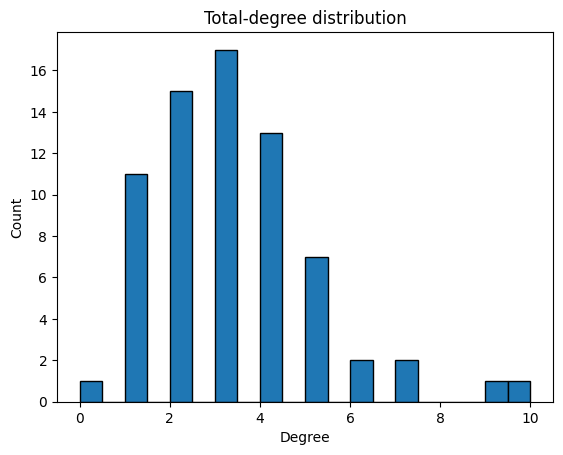

In [308]:
# --- 1. Basic stats
n = G_directed.number_of_nodes()
m = G_directed.number_of_edges()
print(f"Nodes: {n}, Edges: {m}")

# --- 2. Degree stats
in_deg  = dict(G_directed.in_degree())
out_deg = dict(G_directed.out_degree())
tot_deg = {i: in_deg.get(i,0) + out_deg.get(i,0) for i in G_directed.nodes}

# Degree distributions
print("In-degree dist:", Counter(in_deg.values()))
print("Out-degree dist:", Counter(out_deg.values()))
print("Total-degree dist:", Counter(tot_deg.values()))

# Optional: histogram of total degree
plt.hist(list(tot_deg.values()), bins=20, edgecolor='black')
plt.title("Total-degree distribution")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

In [309]:
html_file = "phase1.html" 
notebook: bool = True
colour_scheme: str = "layer" 
node_size_scale: float = 2.0
coord_scale: float = 1000.0

try:
    from pyvis.network import Network
except ImportError:
    raise ImportError("pyvis not found - install with `pip install pyvis`")

net = Network(height="1200px", width="100%", directed=True,
            notebook=notebook, bgcolor="#ffffff", cdn_resources='remote')
net.repulsion()

# Compute each node's total degree
deg_in  = dict(G_directed.in_degree())
deg_out = dict(G_directed.out_degree())
total_deg = {n: deg_in.get(n, 0) + deg_out.get(n, 0) for n in G_directed.nodes}

# -------- nodes (with colours, tooltips, and dynamic sizes) ----------
import matplotlib.colors as mcolors
palette = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())

for n in G_directed.nodes:
    # Build hover title
    title = (
        f"Neuron {n}<br/>"
        f"InDegree: {deg_in.get(n, 0)}<br/>OutDegree: {deg_out.get(n, 0)}"
        f" Z: {coords[n][2] * coord_scale}"
    )

    # Size = (total_degree + 1) * node_size_scale
    size = (total_deg.get(n, 0) + 1) * node_size_scale

    net.add_node(n,
                label=str(n),
                title=title,
                size=size,
                # NOTE: coords[n] is a 3D coordinate, we use only x and z for 2D visualization
                x=coords[n][0] * coord_scale,  # Scale coords to fit in the network view
                y=-coords[n][2] * coord_scale,
                fixed = True)  # Scale coords to fit in the network view)


# -------- edges ------------
for u, v, data in G_directed.edges(data=True):
    w = data.get("weight", None)
    syn_idx = data.get("synapse_index", None)
    dist = data.get("distance", None) * coord_scale  # anatomical distance
    # If distance is missing or zero, fallback to a small positive default
    length = float(dist) if (dist is not None and dist > 0.0) else 50.0

    # Edge thickness ∝ |weight|
    thickness = abs(w) if w is not None else 1.0

    hover_txt = []
    if syn_idx is not None:
        hover_txt.append(f"synapse_index = {syn_idx}")
    if w is not None:
        hover_txt.append(f"weight = {w:.3f}")
    if dist is not None:
        hover_txt.append(f"distance = {dist:.2f}")

    net.add_edge(
        u,
        v,
        value   = thickness * 0.1,         # edge thickness ∝ |weight|
        title   = "<br/>".join(hover_txt),
        # length  = length * 20              # rest‐length ≈ anatomical distance
    )

net.show(html_file)

phase1.html


# Phase II

In [310]:
def phase2_spatial_growth(G, coords, neurons_per_layer, local_conn_per_node, 
                          flow, type_distribution, alpha_type_local, alpha_type_global, global_excit_hub_percentage=0.5,
                          thalamus_layer=None, autapse_prob=[0.8, 0.0, 0.0, 1.0]):
    """
    Phase 2: differentiate neuron types, make sure all neurons have 1 in-degree and 1 out-degree,
    and add long range connections according to flow vector

    G: initial graph from phase 1
    coords: coordinates of neurons
    neurons_per_layer: number of neurons in each layer
    local_conn_per_node: max local out-degree per neuron
    flow: flow vector for long-range connections, shape (3,)
    type_distribution: number distribution of neuron types 
        (global_excit, local_excit, global_inhib, local_inhib), shape (4,)
    alpha_type_local: distance scale parameters for each type, locally, shape (4,)
    alpha_type_global: distance scale parameters for each type, globally, shape (4,)
    """

    if thalamus_layer is not None:
        start = np.sum(neurons_per_layer[:thalamus_layer])
        end = start + neurons_per_layer[thalamus_layer]
        thalamus_idx = np.arange(start, end)

    n_neurons = G.number_of_nodes()

    alpha_local_inhib = alpha_type_local[3]

    # Normalize type distribution
    type_distribution = np.array(type_distribution)
    type_distribution /= np.sum(type_distribution)

    # Number of neurons per type
    number_distribution = (type_distribution * n_neurons).astype(int)

    # If the sum of number_distribution is less/greater than n_neurons,
    # we can add/remove the remaining neurons from a random type
    number_error =  n_neurons - np.sum(number_distribution)
    if number_error > 0:
        for _ in range(number_error):
            # Randomly add one neuron to a random type
            idx = np.random.choice(np.arange(len(number_distribution)))
            number_distribution[idx] += 1
    elif number_error < 0:
        for _ in range(-number_error):
            # Randomly remove one neuron from a random type
            idx = np.random.choice(np.arange(len(number_distribution)))
            if number_distribution[idx] > 0:
                number_distribution[idx] -= 1

    # Build KDTree for fast neighbor queries
    tree = cKDTree(coords)

    # --- Distribute neurons into types according to the type_distribution ---

    # Find the neuron with the highest in+out degree
    max_deg_neuron = max(G.nodes, key=lambda n: G.in_degree(n) + G.out_degree(n))

    global_excit_min_connections = int(global_excit_hub_percentage * max_deg_neuron)

    # Sort neurons by their total degree (in + out)
    nodes_shuffled = list(G.nodes)
    np.random.shuffle(nodes_shuffled)
    sorted_neurons = sorted(nodes_shuffled, key=lambda n: G.in_degree(n) + G.out_degree(n), reverse=True)

    # Filter out the neurons that have less than global_excit_min_connections
    global_excit_neurons = [n for n in sorted_neurons if G.in_degree(n) + G.out_degree(n) >= global_excit_min_connections]

    global_excit_error = len(global_excit_neurons) - number_distribution[0]

    if global_excit_error > 0:
        # Too many global excitatory neurons, remove global_excit_error of the least connected ones
        global_excit_neurons = global_excit_neurons[:-global_excit_error] 

    # Add the least connected neurons to local inhibitory neurons
    local_inhib_neurons = sorted_neurons[-number_distribution[3]:]

    # Find the remaining indices that is not in global_excit_neurons or local_inhib_neurons
    remaining_neurons = [n for n in sorted_neurons if n not in global_excit_neurons and n not in local_inhib_neurons]

    # Find what number of types we have left to fill
    remaining_types = number_distribution.copy()
    remaining_types[0] -= len(global_excit_neurons)
    remaining_types[3] -= len(local_inhib_neurons)
    # Now we can fill the remaining types with the remaining neurons randomly
    local_excit_neurons = []
    global_inhib_neurons = []
    # Shuffle the remaining neurons to randomize the selection
    np.random.shuffle(remaining_neurons)
    for n in remaining_neurons:
        if remaining_types[1] > 0:
            local_excit_neurons.append(n)
            remaining_types[1] -= 1
        elif remaining_types[2] > 0:
            global_inhib_neurons.append(n)
            remaining_types[2] -= 1
        elif remaining_types[0] > 0:
            global_excit_neurons.append(n)
            remaining_types[0] -= 1

    assert len(global_excit_neurons) == number_distribution[0], "Global excitatory neurons count mismatch"
    assert len(local_excit_neurons) == number_distribution[1], "Local excitatory neurons count mismatch"
    assert len(global_inhib_neurons) == number_distribution[2], "Global inhibitory neurons count mismatch"
    assert len(local_inhib_neurons) == number_distribution[3], "Local inhibitory neurons count mismatch"
    assert G.number_of_nodes() == sum(number_distribution), "Total number of neurons mismatch"
    
    # Add type as data to each node
    for n in global_excit_neurons:
        G.nodes[n]['type'] = 'global_excit'
    for n in local_excit_neurons:
        G.nodes[n]['type'] = 'local_excit'
    for n in global_inhib_neurons:
        G.nodes[n]['type'] = 'global_inhib'
    for n in local_inhib_neurons:
        G.nodes[n]['type'] = 'local_inhib'



    # --- Growing dendrites ---

    # Keep track of new dendritic positions
    # List of tuples (node, dendrite_coord)
    dendrites = []

    def draw_dendrite(node, min_length, max_length, alpha_factor=1.0, max_add=3):
        # Anti-flow vector
        dendrite_flow = np.random.uniform(min_length, max_length, size=1) * (-1) * flow(coords[node])
        dendrite_coord = coords[node] + dendrite_flow
        dists, neighs = tree.query(dendrite_coord, k=2*local_conn_per_node + 1)
        candidates = list(zip(neighs, dists))
        np.random.shuffle(candidates)
        num_added = 0
        for j, dist_ij in candidates:
            # Connection probability ∝ exp(−alpha_init * dist_ij)
            p = np.exp(-alpha_type_global[0] * alpha_factor * dist_ij)
            if np.random.rand() < p:
                actual_dist_ij = np.linalg.norm(coords[node] - coords[j])
                G.add_edge(int(j), int(node), distance=actual_dist_ij , dendritic=True)
                num_added += 1
            if num_added >= max_add:
                break

        if num_added > 0:
            dendrites.append((node, dendrite_coord))

    dendrite_length = (0.4, 1.0)
    for i in global_excit_neurons:
        if i not in thalamus_idx:  # Avoid double drawing dendrites
            draw_dendrite(i, *dendrite_length, alpha_factor=0.75, max_add=20)

    # Dendrite coords
    dendrite_coords = np.array([d[1] for d in dendrites])
    # Dendrite nodes
    dendrite_nodes = np.array([d[0] for d in dendrites])
    # Make separate KDTree for dendrite coords
    dendrite_tree = cKDTree(dendrite_coords)

    # --- Growing global axons ---

    def draw_global_axon(node, min_length, max_length, with_flow=True, alpha_factor=1.0, max_add=3):
        # Flow vector
        flow_sign = 1.0 if with_flow else -1.0
        axon_flow = flow_sign * np.random.uniform(min_length, max_length, size=1) * flow(coords[node])
        axon_coord = coords[node] + axon_flow
        dists, neighs = tree.query(axon_coord, k=2*local_conn_per_node + 1)
        candidates = list(zip(neighs, dists))
        np.random.shuffle(candidates)
        num_added = 0
        for j, dist_ij in candidates:
            # Connection probability ∝ exp(−alpha_init * dist_ij)
            p = np.exp(-alpha_type_global[0] * alpha_factor * dist_ij)
            if np.random.rand() < p:
                actual_dist_ij = np.linalg.norm(coords[node] - coords[j])
                G.add_edge(int(node), int(j), distance=actual_dist_ij , axonal=True)
                num_added += 1
            if num_added >= max_add:
                break

    axon_length_flow = (0.4, 2.0)
    # Axons with flow
    for i in global_excit_neurons:
        draw_global_axon(i, *axon_length_flow , with_flow=True, alpha_factor=0.75, max_add=20)

    axon_length_anti_flow = (0.4, 1.0)
    # Draw some axons against flow
    for i in global_excit_neurons:
        draw_global_axon(i, *axon_length_anti_flow , with_flow=False, alpha_factor=1.5, max_add=20)


    # Draw some global_inhib axons against flow
    for i in global_inhib_neurons:
        draw_global_axon(i, *axon_length_anti_flow , with_flow=False, alpha_factor=1.5, max_add=20)



    # --- Draw thalamic axons if thalamus_layer is specified ---
    if thalamus_layer is not None:
        def draw_thalamus_axon(node, min_length, max_length, with_flow=False, alpha_axon=1.5, alpha_dendrite=1.0,
                                max_axon=3, max_dendrite=6):
            # Flow vector
            flow_sign = 1.0 if with_flow else -1.0
            axon_flow = flow_sign * np.random.uniform(min_length, max_length, size=1) * flow(coords[node])
            axon_coord = coords[node] + axon_flow
            dists, neighs = tree.query(axon_coord, k=2*local_conn_per_node + 1)

            candidates = list(zip(neighs, dists))
            np.random.shuffle(candidates)
            num_added = 0
            for j, dist_ij in candidates:
                # Connection probability ∝ exp(−alpha_init * dist_ij)
                p = np.exp(-alpha_type_global[0] * alpha_axon * dist_ij)
                if np.random.rand() < p:
                    actual_dist_ij = np.linalg.norm(coords[node] - coords[j])
                    G.add_edge(int(node), int(j), distance=actual_dist_ij, axonal=True)
                    num_added += 1
                if num_added >= max_axon:
                    break
            
            # Use dendrite_tree to find neighbors
            if len(dendrite_coords) > 0:
                dists_dendrites, neighs_dendrites = dendrite_tree.query(axon_coord, k=2*local_conn_per_node + 1)
                candidates_dendrites = list(zip(neighs_dendrites, dists_dendrites))
                np.random.shuffle(candidates_dendrites)
                num_added_dendrites = 0
                for j, dist_ij in candidates_dendrites:
                    # Connection probability ∝ exp(−alpha_init * dist_ij)
                    p = np.exp(-alpha_type_global[0] * alpha_dendrite * dist_ij)
                    if np.random.rand() < p:
                        # Speed is dominated by the dendrite length
                        actual_dist_ij = np.linalg.norm(coords[dendrite_nodes[j]] - dendrite_coords[j])
                        G.add_edge(int(node), int(dendrite_nodes[j]), distance=actual_dist_ij, dendritic=True)
                        num_added_dendrites += 1
                    if num_added_dendrites >= max_dendrite:
                        break

        thalamus_axon_length = (1.2, 2.5)
        # Draw thalamic axons
        if thalamus_layer is not None:
            for i in thalamus_idx:
                if i in global_excit_neurons:  # Only draw axons for global excitatory neurons in thalamus
                    draw_thalamus_axon(i, *thalamus_axon_length, with_flow=False, alpha_axon=1.0, alpha_dendrite=0.75,
                                max_axon=10, max_dendrite=20)

    # --- Growing local axons ---
    # Local axons do not depend on flow
    def draw_local_axon(node, max_length, alpha_main, alpha_factor=1.0, max_add=5):
        dists, neighs = tree.query(coords[node], k=2*local_conn_per_node + 1)
        candidates = list(zip(neighs[1:], dists[1:]))
        np.random.shuffle(candidates)
        num_added = 0
        for j, dist_ij in candidates:
            # Connection probability ∝ exp(−alpha_init * dist_ij)
            if dist_ij > max_length:
                continue
            p = np.exp(-alpha_main * alpha_factor * dist_ij)
            if np.random.rand() < p:
                G.add_edge(int(node), int(j), distance=dist_ij)
                num_added += 1
            if num_added >= max_add:
                break


    # Draw local axons for local inhibitory neurons
    for i in local_inhib_neurons:
        draw_local_axon(i, max_length=0.35, alpha_main=alpha_type_local[3], alpha_factor=0.5, max_add=20)

    # Draw local axons for local excitatory neurons
    for i in local_excit_neurons:
        draw_local_axon(i, max_length=0.35, alpha_main=alpha_type_local[1], alpha_factor=0.5, max_add=20)

    # Draw local axons for global inhibitory neurons
    for i in global_inhib_neurons:
        draw_local_axon(i, max_length=0.35, alpha_main=alpha_type_local[2], alpha_factor=0.5, max_add=20)

    # Draw local axons for global excitatory neurons
    for i in global_excit_neurons:
        draw_local_axon(i, max_length=0.35, alpha_main=alpha_type_local[0], alpha_factor=0.5, max_add=20)






    # Find neurons with no in-degree or out-degree, and add a reciprocal connection
    no_in_out = [n for n in G.nodes if G.in_degree(n) == 0 and G.out_degree(n) == 0]
    for i in no_in_out:
        drawn = False
        dists, neighs = tree.query(coords[i], k=2*local_conn_per_node + 1)
        candidates = list(zip(neighs[1:], dists[1:]))
        np.random.shuffle(candidates)
        num_added = 0
        count = 0 # To avoid infinite loop
        while not drawn:
            for j, dist_ij in candidates:
                p = np.exp(-alpha_local_inhib * 1 * dist_ij) # + 0.01 * count
                if np.random.rand() < p:
                    G.add_edge(i, int(j), distance=dist_ij)
                    G.add_edge(int(j), i, distance=dist_ij)
                    drawn = True
                    break
            count += 1


    # Find neurons with either no in-degree or no out-degree, and add a reciprocal connection to ceil(n_neighbors / 2)
    no_in = [n for n in G.nodes if G.in_degree(n) == 0]
    for i in no_in:
        n_out = G.out_degree(i)
        dists, neighs = tree.query(coords[i], k=2*local_conn_per_node + 1)
        candidates = list(zip(neighs[1:], dists[1:]))
        np.random.shuffle(candidates)
        num_added = 0
        count = 0 # To avoid infinite loop
        while num_added < np.ceil(n_out / 2):
            for j, dist_ij in candidates:
                p = np.exp(-alpha_type_local[1]  * 1 * dist_ij) #+ 0.01 * count
                if np.random.rand() < p:
                    G.add_edge(int(j), i, distance=dist_ij)
                    num_added += 1
            count += 1

    no_out = [n for n in G.nodes if G.out_degree(n) == 0]
    for i in no_out:
        n_in = G.in_degree(i)
        dists, neighs = tree.query(coords[i], k=2*local_conn_per_node + 1)
        candidates = list(zip(neighs[1:], dists[1:]))
        np.random.shuffle(candidates)
        num_added = 0
        count = 0 # To avoid infinite loop
        while num_added < np.ceil(n_in / 2):
            for j, dist_ij in candidates:
                p = np.exp(-alpha_type_local[1] * 1 * dist_ij)# + 0.01 * count
                if np.random.rand() < p:
                    G.add_edge(i, int(j), distance=dist_ij)
                    num_added += 1
            count += 1


    # Draw autapses according to the autapse_prob
    for i in G.nodes:
        if G.nodes[i]['type'] == 'global_excit' and np.random.rand() < autapse_prob[0]:
            # Distance is average distance to neighbors
            dists, neighs = tree.query(coords[i], k=local_conn_per_node + 1)
            distance = np.mean(dists[1:])
            # Global excit autapses are dominated by dendritic speeds
            G.add_edge(i, i, distance=distance, dendritic=True)
        elif G.nodes[i]['type'] == 'local_excit' and np.random.rand() < autapse_prob[1]:
            # Distance is average distance to neighbors
            dists, neighs = tree.query(coords[i], k=local_conn_per_node + 1)
            distance = np.mean(dists[1:])
            G.add_edge(i, i, distance=distance)
        elif G.nodes[i]['type'] == 'global_inhib' and np.random.rand() < autapse_prob[2]:
            # Distance is average distance to neighbors
            dists, neighs = tree.query(coords[i], k=local_conn_per_node + 1)
            distance = np.mean(dists[1:])
            G.add_edge(i, i, distance=distance)
        elif G.nodes[i]['type'] == 'local_inhib' and np.random.rand() < autapse_prob[3]:
            # Distance is average distance to neighbors
            dists, neighs = tree.query(coords[i], k=local_conn_per_node + 1)
            distance = np.mean(dists[1:])
            G.add_edge(i, i, distance=distance)


    # Prune edges for nodes that have more than local_conn_per_node out-degree
    # by removing shortest edges until the out-degree is local_conn_per_node
    for i in G.nodes:
        out_degree = G.out_degree(i)
        if out_degree > local_conn_per_node:
            # Get all edges from this node
            edges = list(G.out_edges(i, data=True))
            # Sort edges by distance
            edges_sorted = sorted(edges, key=lambda x: x[2]['distance'])
            # Remove autapses from the list of edges to remove
            edges_sorted = [e for e in edges_sorted if not e[0] == e[1]]
            # Remove the shortest edges until we reach the desired out-degree
            for j in range(out_degree - local_conn_per_node):
                G.remove_edge(i, edges_sorted[j][1])

    return G, coords, neurons_per_layer

In [311]:
def flow_vector(coords):
    """
    Generate a flow vector for long-range connections.
    coords: coordinates of neurons 
    """
    return np.array([0.0, 0.0, -1.0])  # Example flow vector pointing downwards


type_distribution = np.array([0.5, 0.2, 0.15, 0.15])  # Distribution of neuron types
alpha_type_local = np.array([15, 15, 15, 15])  # Distance scale parameters for each type
alpha_type_global = np.array([15, 15, 15, 15])  # Distance scale parameters for each type
thalamus_layer = 2  # Index of the thalamus layer in layer_bounds

G_directed, coords, neurons_per_layer = phase2_spatial_growth(G_directed, coords, neurons_per_layer, 
                                                              out_max, flow_vector, type_distribution, 
                                                              alpha_type_local, alpha_type_global,
                                                              thalamus_layer=thalamus_layer) 

In [312]:
# Find the node with highest out degree
max_out_node = max(G_directed.nodes, key=lambda n: G_directed.out_degree(n))
print(f"Node with highest out degree: {max_out_node}, out degree: {G_directed.out_degree(max_out_node)}")
# Find the node with highest in degree
max_in_node = max(G_directed.nodes, key=lambda n: G_directed.in_degree(n))
print(f"Node with highest in degree: {max_in_node}, in degree: {G_directed.in_degree(max_in_node)}")

Node with highest out degree: 38, out degree: 14
Node with highest in degree: 3, in degree: 11


## Small world?

In [313]:
G_undirected = G_directed.to_undirected()
# Prune unconnected nodes
G_undirected.remove_nodes_from(list(nx.isolates(G_undirected)))
# Make it so that graph is connected
if not nx.is_connected(G_undirected):
    largest_cc = max(nx.connected_components(G_undirected), key=len)
    G_undirected = G_undirected.subgraph(largest_cc).copy()

# print(smallworld.sigma(G_undirected, 20, 2))
# print(smallworld.omega(G_undirected, 2, 4))

Nodes: 70, Edges: 343
In-degree dist: Counter({3: 14, 5: 13, 6: 10, 7: 8, 2: 7, 4: 7, 8: 7, 1: 2, 11: 1, 9: 1})
Out-degree dist: Counter({4: 13, 6: 13, 3: 11, 7: 9, 5: 9, 2: 7, 8: 3, 1: 2, 9: 2, 14: 1})
Total-degree dist: Counter({9: 11, 11: 9, 7: 9, 14: 6, 5: 6, 12: 6, 6: 5, 8: 5, 13: 4, 15: 3, 4: 1, 21: 1, 18: 1, 16: 1, 3: 1, 10: 1})


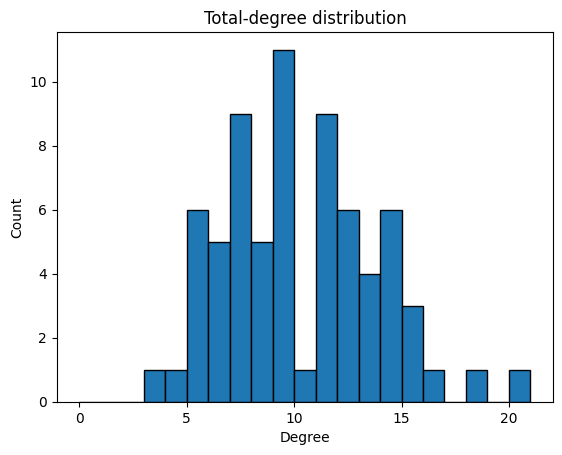

In [314]:
# --- 1. Basic stats
n = G_directed.number_of_nodes()
m = G_directed.number_of_edges()
print(f"Nodes: {n}, Edges: {m}")

# --- 2. Degree stats
in_deg  = dict(G_directed.in_degree())
out_deg = dict(G_directed.out_degree())
tot_deg = {i: in_deg.get(i,0) + out_deg.get(i,0) for i in G_directed.nodes}

# Degree distributions
print("In-degree dist:", Counter(in_deg.values()))
print("Out-degree dist:", Counter(out_deg.values()))
print("Total-degree dist:", Counter(tot_deg.values()))

# Optional: histogram of total degree
bins = np.arange(0, max(tot_deg.values()) + 1, 1)  # Adjust bins as needed
plt.hist(list(tot_deg.values()), bins=bins, edgecolor='black')
plt.title("Total-degree distribution")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

In [315]:
html_file = "phase2.html" 
notebook: bool = True
colour_scheme: str = "layer" 
node_size_scale: float = 2.0
coord_scale: float = 1000.0

try:
    from pyvis.network import Network
except ImportError:
    raise ImportError("pyvis not found - install with `pip install pyvis`")

net = Network(height="1200px", width="100%", directed=True,
            notebook=notebook, bgcolor="#ffffff", cdn_resources='remote')
net.repulsion()

# Compute each node's total degree
deg_in  = dict(G_directed.in_degree())
deg_out = dict(G_directed.out_degree())
total_deg = {n: deg_in.get(n, 0) + deg_out.get(n, 0) for n in G_directed.nodes}

# -------- nodes (with colours, tooltips, and dynamic sizes) ----------
import matplotlib.colors as mcolors
palette = list(mcolors.TABLEAU_COLORS.values()) + list(mcolors.CSS4_COLORS.values())

for n in G_directed.nodes:
    # Build hover title
    title = (
        f"Neuron {n}"
        f" InDegree: {deg_in.get(n, 0)}OutDegree: {deg_out.get(n, 0)}"
        f" Type: {G_directed.nodes[n].get('type', 'unknown')}"
        # f" Z: {coords[n][1]}"
    )

    # Size = (total_degree + 1) * node_size_scale
    size = (total_deg.get(n, 0) + 1) * node_size_scale

    color = "#1f77b4"  # Default color for nodes
    neuron_type = G_directed.nodes[n].get('type', 'unknown')
    if neuron_type == 'global_excit':
        color = "#1920e9"
    elif neuron_type == 'local_excit':
        color = "#0effa7"
    elif neuron_type == 'global_inhib':
        color = "#eca80c"
    elif neuron_type == 'local_inhib':
        color = "#d62728"

    net.add_node(n,
                label=str(n),
                title=title,
                size=size,
                # NOTE: coords[n] is a 3D coordinate, we use only x and z for 2D visualization
                x=coords[n][0] * coord_scale,  # Scale coords to fit in the network view
                y=-coords[n][2] * coord_scale,
                color=color,
                fixed = True)  # Scale coords to fit in the network view)


# -------- edges ------------
for u, v, data in G_directed.edges(data=True):
    w = data.get("weight", None)
    syn_idx = data.get("synapse_index", None)
    dist = data.get("distance", None)  # anatomical distance
    # If distance is missing or zero, fallback to a small positive default
    length = float(dist) if (dist is not None and dist > 0.0) else 50.0

    # Edge thickness ∝ |weight|
    thickness = abs(w) if w is not None else 1.0

    hover_txt = []
    if syn_idx is not None:
        hover_txt.append(f"synapse_index = {syn_idx}")
    if w is not None:
        hover_txt.append(f"weight = {w:.3f}")
    if dist is not None:
        hover_txt.append(f"distance = {dist:.2f}")

    edge_color = "#1f77b4"  # Default color for edges
    dendritic = data.get("dendritic", False)
    axonal = data.get("axonal", False)
    if dendritic:
        edge_color = "#a02c2c"
    if axonal:
        edge_color = "#17cdab"

    net.add_edge(
        u,
        v,
        value   = thickness * 0.1,         # edge thickness ∝ |weight|
        title   = "<br/>".join(hover_txt),
        color = edge_color,
        # length  = length * 20              # rest‐length ≈ anatomical distance
    )

net.show(html_file)

phase2.html


# Build connectome

In [316]:
def neuron_pop_and_connectome_from_graph(G, coords, neurons_per_layer,
                                         class1_type_dist, class2_type_dist, class3_type_dist, class4_type_dist,
                                         threshold_decay, delta_V=2.5, bias=0.0, threshold_mult=1.05, n_params=13):
    """
    Create a Neuron population and Connectome object from the graph G.
    classx_types: lists of tuples (type_name, type_prob, layer_factor[n_layers]) for each class of neurons
    """

    n_neurons = G.number_of_nodes()
    # Max out-degree
    max_out_degree = max(G.out_degree(n) for n in G.nodes)
    max_synapses = max_out_degree

    # Nodal parameters
    neuron_population = np.zeros((n_neurons, n_params))
    inhibitory_mask = np.zeros(n_neurons, dtype=bool)
    neuron_population_types = []
    
    n_template_params = len(neuron_type_IZ["nb1"]) # Usually 9

    # Edge parameters
    M = np.zeros((n_neurons, max_synapses), dtype=int)
    NC = np.ones((n_neurons, max_synapses), dtype=bool) # Neuron Connection
    distance = np.zeros((n_neurons, max_synapses), dtype=float)
    dendritic = np.zeros((n_neurons, max_synapses), dtype=bool)



    # Assign neuron types and parameters
    for i, n in enumerate(G.nodes):
        # Assign neuron type based on the type distribution
        neuron_type = G.nodes[n].get('type', 'unknown')
        # Find layer index based on the node index
        layer_idx = np.searchsorted(np.cumsum(neurons_per_layer) - 1, i)
        class1_types = [p[0] for p in class1_type_dist]
        class2_types = [p[0] for p in class2_type_dist]
        class3_types = [p[0] for p in class3_type_dist]
        class4_types = [p[0] for p in class4_type_dist]
        class1_probs = np.array([p[1]*p[2][layer_idx] for p in class1_type_dist], dtype=float)
        class1_probs /= np.sum(class1_probs)  # Normalize probabilities
        class2_probs = np.array([p[1]*p[2][layer_idx] for p in class2_type_dist], dtype=float)
        class2_probs /= np.sum(class2_probs)  # Normalize probabilities
        class3_probs = np.array([p[1]*p[2][layer_idx] for p in class3_type_dist], dtype=float)
        class3_probs /= np.sum(class3_probs)  # Normalize probabilities
        class4_probs = np.array([p[1]*p[2][layer_idx] for p in class4_type_dist], dtype=float)
        class4_probs /= np.sum(class4_probs)  # Normalize probabilities
        if neuron_type == 'global_excit':
            neuron_type = np.random.choice(class1_types, p=class1_probs)
            neuron_population_types.append(neuron_type)
            neuron_population[i, :n_template_params] = neuron_type_IZ[neuron_type]
            inhibitory_mask[i] = False
        elif neuron_type == 'local_excit':
            neuron_type = np.random.choice(class2_types, p=class2_probs)
            neuron_population_types.append(neuron_type)
            neuron_population[i, :n_template_params] = neuron_type_IZ[neuron_type]
            inhibitory_mask[i] = False
        elif neuron_type == 'global_inhib':
            neuron_type = np.random.choice(class3_types, p=class3_probs)
            neuron_population_types.append(neuron_type)
            neuron_population[i, :n_template_params] = neuron_type_IZ[neuron_type]
            inhibitory_mask[i] = True
        elif neuron_type == 'local_inhib':
            neuron_type = np.random.choice(class4_types, p=class4_probs)
            neuron_population_types.append(neuron_type)
            neuron_population[i, :n_template_params] = neuron_type_IZ[neuron_type]
            inhibitory_mask[i] = True
        else:
            raise ValueError(f"Unknown neuron type: {neuron_type}")

    # Assign other parameters 
    neuron_population[:, 9] = delta_V
    neuron_population[:, 10] = bias
    neuron_population[:, 11] = threshold_mult
    neuron_population[:, 12] = threshold_decay


    # Assign edge parameters
    for i, n in enumerate(G.nodes):
        out_edges = list(G.out_edges(n, data=True))
        for j, (u, v, data) in enumerate(out_edges):
            M[i, j] = v  # Target neuron index
            NC[i, j] = False # No no-connection
            distance[i, j] = data.get("distance", 0.0)  # Anatomical distance
            dendritic[i, j] = data.get("dendritic", False)  # Dendritic connection


    # Create Neuron population and Connectome objects
    neuron_population_class = NeuronPopulation(neurons_per_layer=neurons_per_layer, neuron_distribution=None,
                                         neuron_types=None, inhibitory=None, threshold_decay=threshold_decay,
                                         threshold_mult=threshold_mult, delta_V=delta_V, bias=bias, auto_populate=False,)

    neuron_population_class.neuron_population = neuron_population
    neuron_population_class.inhibitory_mask = inhibitory_mask
    neuron_population_class.neuron_population_types = neuron_population_types


    # Create Connectome object
    connectome = Connectome(max_synapses=max_synapses, neuron_population=neuron_population_class, connectivity_probability=None, 
                             autobuild=False)

    connectome.M = M
    connectome.NC = NC
    connectome.distances = distance
    connectome.dendritic = dendritic

    return neuron_population_class, connectome


In [317]:
class1_type_dist = [("p23", 0.5, [1, 1, 0]), ("p5_p6", 0.5, [1, 1, 0]), ("TC", 1, [0, 0, 1])]  # Global excitatory neuron types
class2_type_dist = [("ss4", 1, [1, 1, 0]), ("TC", 1, [0, 0, 1])]  # Local excitatory neuron types
class3_type_dist = [("nb1", 0.5, [1, 0, 0]), ("nb", 0.5, [0, 1, 0]), ("TI", 1.0, [0, 0, 1])]  # Global inhibitory neuron types
class4_type_dist = [("b", 1, [1, 1, 0]), ("TRN", 1, [0, 0, 1])]  # Local inhibitory neuron types

neuron_pop, connectome = neuron_pop_and_connectome_from_graph(G_directed, coords, neurons_per_layer,
                                         class1_type_dist=class1_type_dist, class2_type_dist=class2_type_dist,
                                            class3_type_dist=class3_type_dist, class4_type_dist=class4_type_dist,
                                            threshold_decay=0.1)